In [1]:
import pandas as pd
import obspy as obs
import matplotlib.pyplot as plt

from obspy.signal import PPSD
from andbro__querrySeismoData import __querrySeismoData
from andbro__makeplot_trace_spectrum import __makeplot_trace_and_spectrum
from andbro__filterStream import __filterStream
# from andbro__makeplot_trace_spectrogram import __makeplot_trace_spectrogram
from andbro__rotate_STS2 import __rotate_STS2

In [2]:
def __get_inventory_from_client(config):

    from obspy.clients.fdsn import Client

    cli = Client(base_url=config['client'], timeout=100)

    try:
        inv = cli.get_stations(network=config['seed'].split(".")[0],
                               station=config['seed'].split(".")[1],
                               location=config['seed'].split(".")[2],
                               channel='*',
                               starttime=tbeg,
                               endtime=tend,
                               level="response")
    except:
        print(f"ERROR: failed to load inventory for {config['seed'].split('.')[1]}!")

    return inv

In [13]:
config = {}

config['seed'] = "BW.GELB..BH*"

# config['tbeg'] = "2023-02-09 16:00"
# config['tend'] = "2023-02-10 06:00"

config['tbeg'] = "2023-04-05 12:00"
config['tend'] = "2023-04-05 13:00"

config['repository'] = "jane" ## archive, jane, george, local
config['path'] = None


# config['path'] = "/home/brotzer/Documents/ROMY/STS2/STS2_BIB_Check/TONSTS2+ROTZ+Platte/mseed/BH*.D/*"

## Load Data

In [14]:
st00, inv = __querrySeismoData(
                            seed_id=config.get("seed"),
                            starttime=config.get("tbeg"),
                            endtime=config.get("tend"),
                            repository=config.get("repository"),
                            path=config['path'],
                            restitute=None,
                            detail=None,
                            fill_value=None,
                            )



st00.plot(equal_scale=False);

FDSNNoDataException: No data available for request.
Detailed response of server:



### Load Local Data

In [67]:
## TON STS2
# datapath="/home/brotzer/Documents/ROMY/STS2/STS2_BIB_Check/TONSTS2+ROTZ+Platte/mseed/BH*.D/*"
# tbeg="2021-12-10 00:00"
# tend="2021-12-10 06:00"

In [68]:
## ROTZ STS2
# datapath="/import/kilauea-data/ROMY/STS2/STS2_BIB_Check/ROTZSTS2+TON/mseed/HH*.D/*"
# tbeg="2022-02-01 18:00"
# tend="2022-02-02 01:00"

In [69]:
# st0 = obs.read(datapath)
# st0.merge()
# st0.trim(starttime=obs.UTCDateTime(tbeg), endtime=obs.UTCDateTime(tend))

In [70]:
# ## check for NaN in data and create masks

# from numpy import isnan,ones,nan

# masks, masks_empty = [], True

# for tr in st0:
#     if isnan(tr.data).any():
#         mask = ones(len(tr.data))
#         for i, e in enumerate(tr.data):
#             if isnan(e):
#                 tr.data[i] = 0
#                 mask[i] = nan
#         print("created masks for NaN values ")
#         masks.append(mask)
#         masks_empty = False
#     else:
#         masks.append([])

## Rotate to UVW

In [71]:
st_rot = __rotate_STS2(st00, mode="ZNE->UVW")

In [72]:
# st_rot.resample(100)
# st_rot.detrend('demean')
# st_rot.taper(0.1)

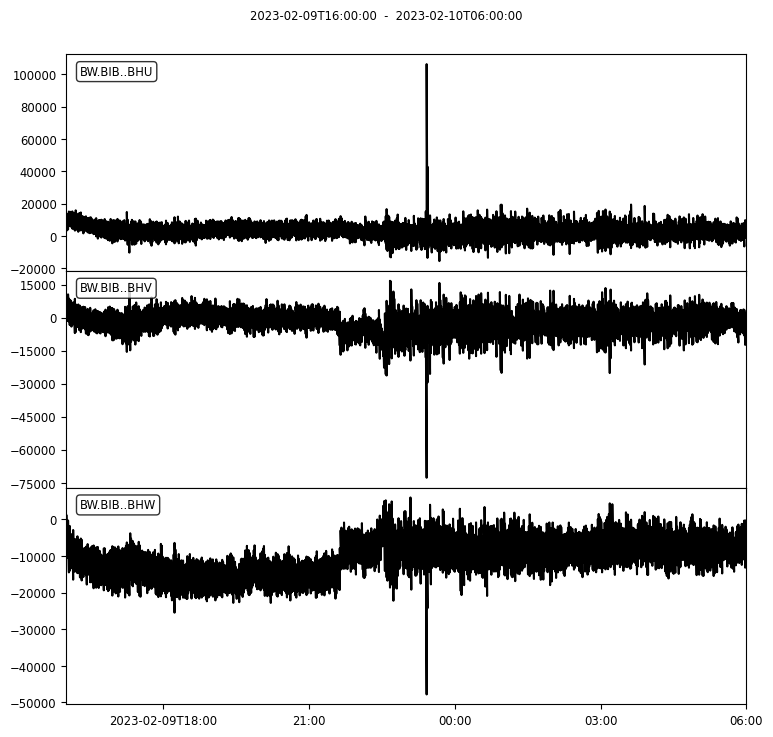

In [73]:
st_rot.plot(equal_scale=False);
# st_rot.spectrogram()

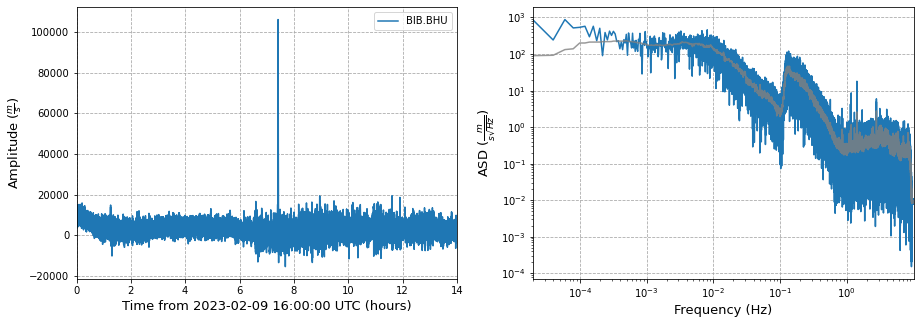

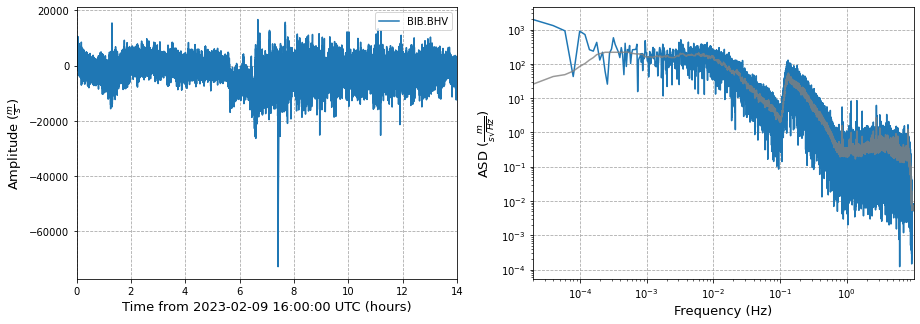

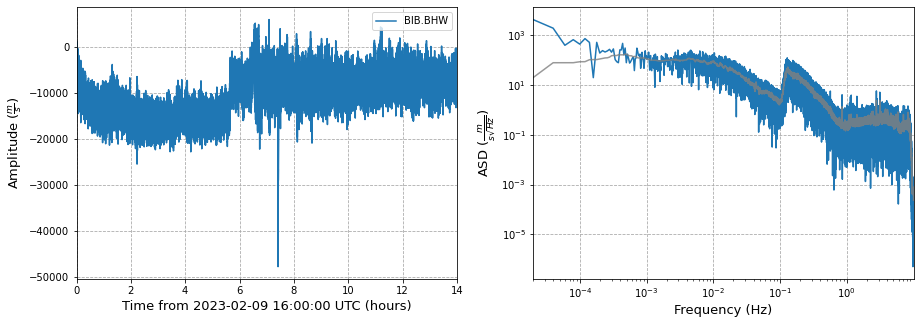

In [74]:
for tr in st_rot:
#     __makeplot_trace_and_spectrum(tr, fmax=0.25/tr.stats.delta, grid=True);
    __makeplot_trace_and_spectrum(tr, fmax=0.5/tr.stats.delta, axis_scale="loglog", grid=True, smoothing=50);
plt.show();

In [38]:
params = [None, 512, 128]

for tr in st_rot:
    __makeplot_trace_spectrogram(tr, unit='hour', normalize=True, spec_param=params);
plt.show();

NameError: name '__makeplot_trace_spectrogram' is not defined

## Remove response and process

In [14]:
# inv = __get_inventory_from_client(config)

# inv = obs.read_inventory("/home/brotzer/Desktop/1111_STS2.xml")


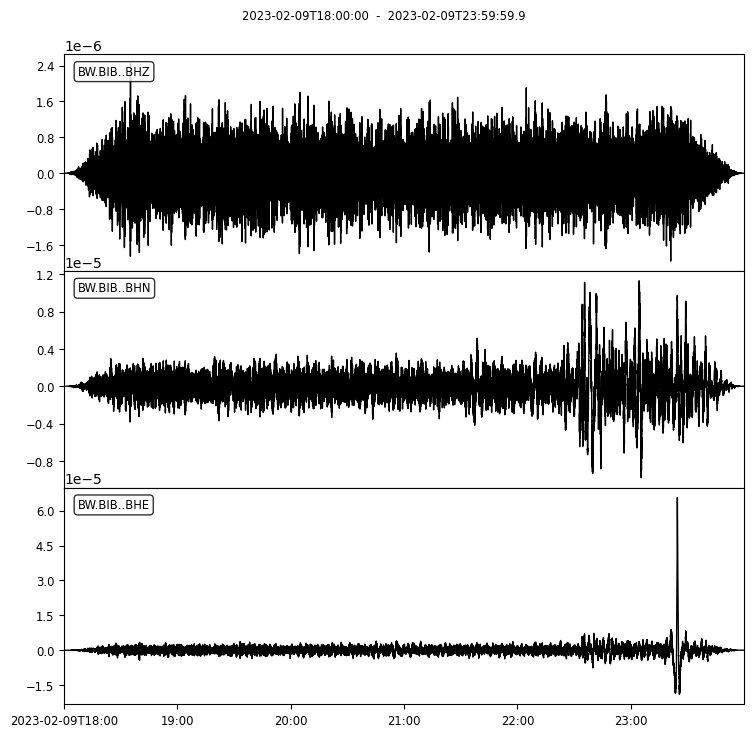

In [18]:
st_vel = st00.copy()

if st_vel[0].stats.channel[0] == 'H':
    st_vel.remove_response(inventory=inv, pre_filt=[2e-3, 8e-3, 90, 100], output="VEL", zero_mean=True);
    st_vel.resample(100)
elif st_vel[0].stats.channel[0] == 'B':
    st_vel.remove_response(inventory=inv, pre_filt=[2e-3, 8e-3, 8, 10], output="VEL", zero_mean=True);
    st_vel.resample(10)

st_vel.detrend("simple")
st_vel.taper(0.1)
st_vel.plot(equal_scale=False);

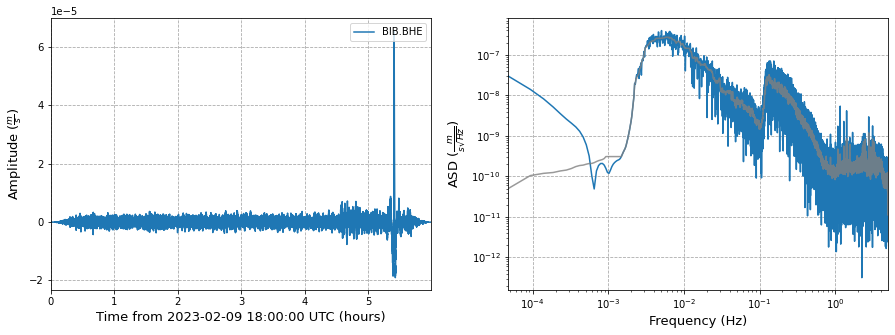

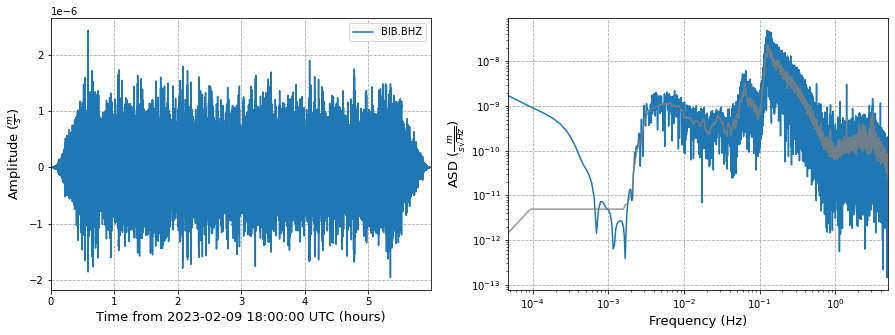

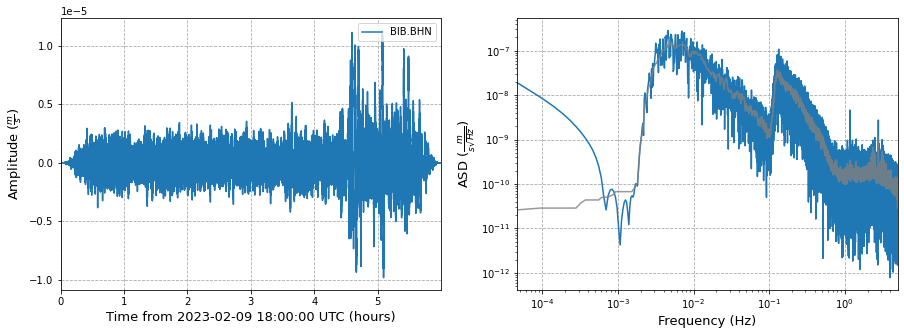

In [19]:
for tr in st_vel:
#     __makeplot_trace_and_spectrum(tr, fmax=0.25/tr.stats.delta, grid=True);
    __makeplot_trace_and_spectrum(tr, fmax=0.5/tr.stats.delta, axis_scale="loglog", grid=True, smoothing=40);
plt.show();

In [20]:
params = [None, 128, 64]
for tr in st_vel:
    __makeplot_trace_spectrogram(tr, unit='hour', normalize=True, spec_param=params);
plt.show();

NameError: name '__makeplot_trace_spectrogram' is not defined

## Filter Data

In [18]:
config['setFilter'] = True
config['filter_type'] = 'bandpass'
config['filter_corners'] = [0.2, 2]

st = st_vel.copy()

st = st.detrend('demean')
st = st.taper(0.1)
st = __filterStream(st, config)
st = st.resample(config['filter_corners'][1]*2)


 Filtering: bandpass [0.2, 2]...

 TON.HHE.: Applying bandpass 0.2 - 2 Hz
 TON.HHN.: Applying bandpass 0.2 - 2 Hz
 TON.HHZ.: Applying bandpass 0.2 - 2 Hz


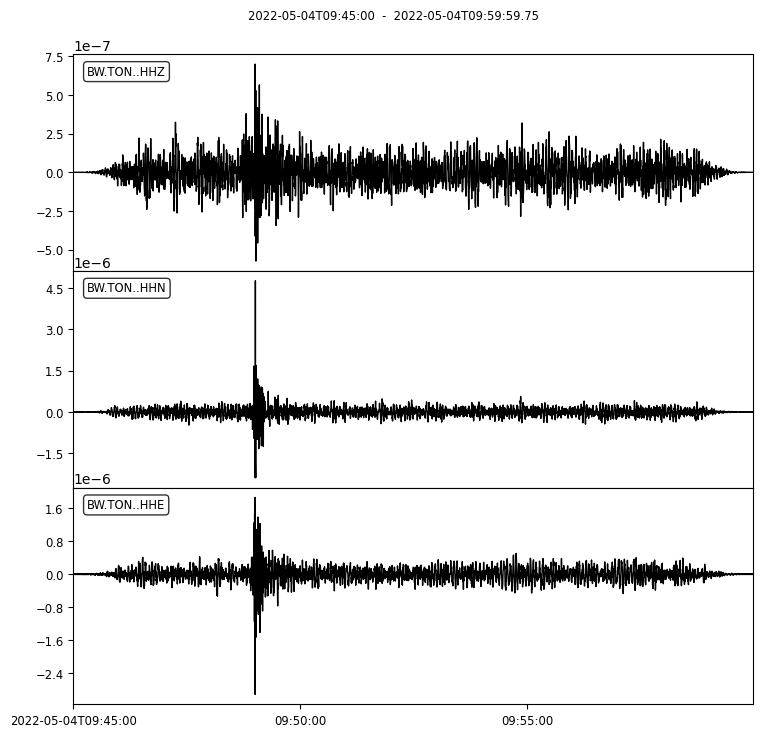

In [19]:
st.plot(equal_scale=False);

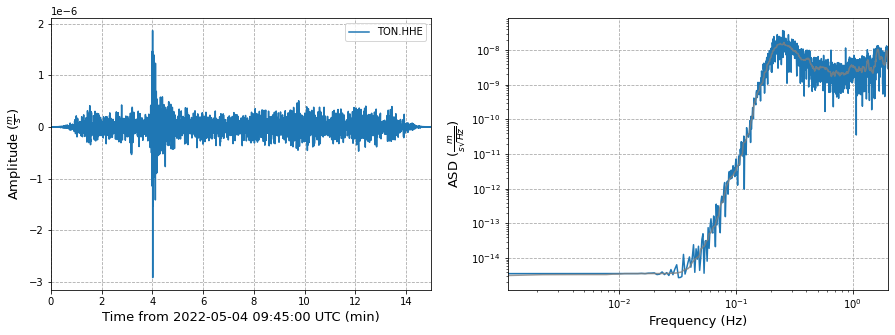

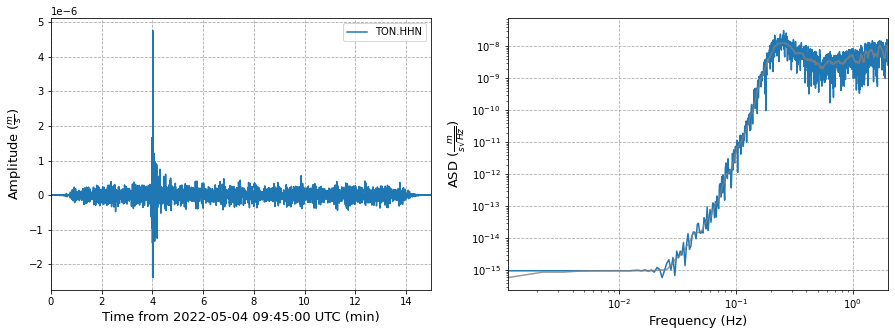

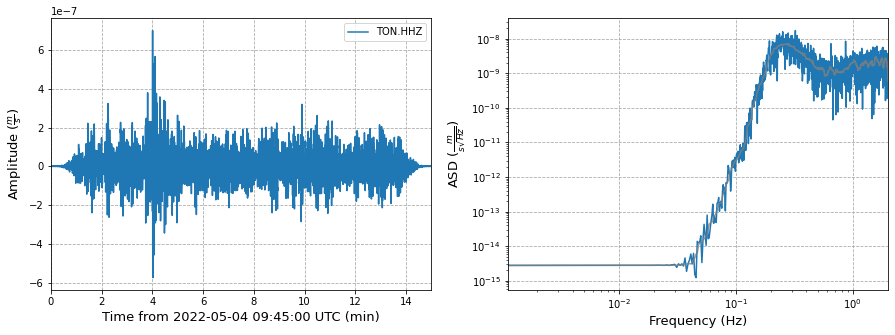

In [20]:
for tr in st:
#     __makeplot_trace_and_spectrum(tr, fmax=config['filter_corners'][1], grid=True);
    __makeplot_trace_and_spectrum(tr, fmax=config['filter_corners'][1], axis_scale="loglog", grid=True, smoothing=50);
plt.show();

Using windows of 3.52 seconds 


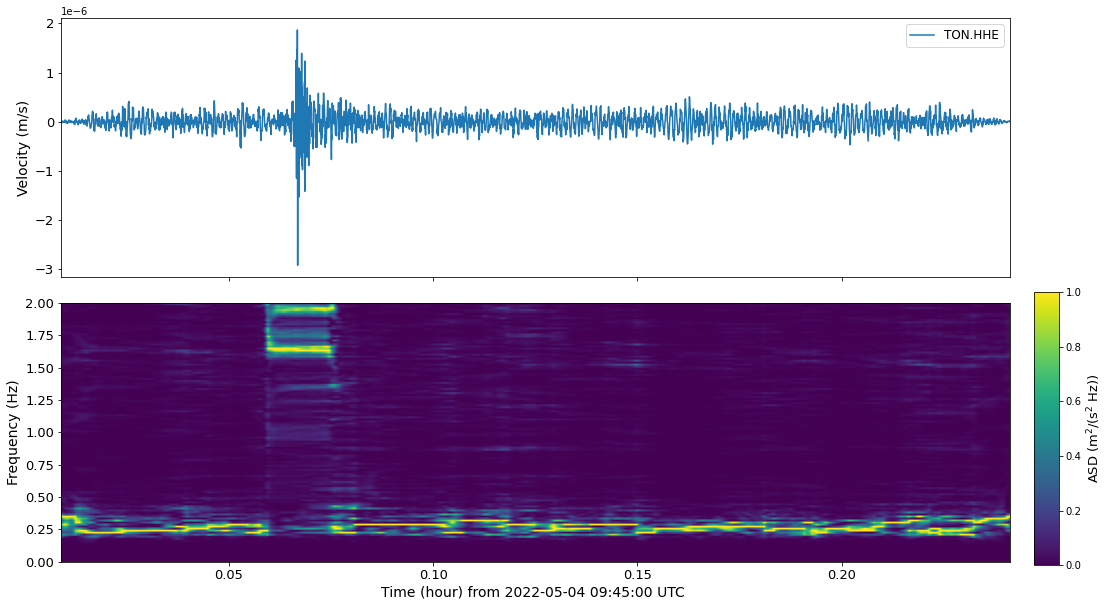

Using windows of 3.52 seconds 


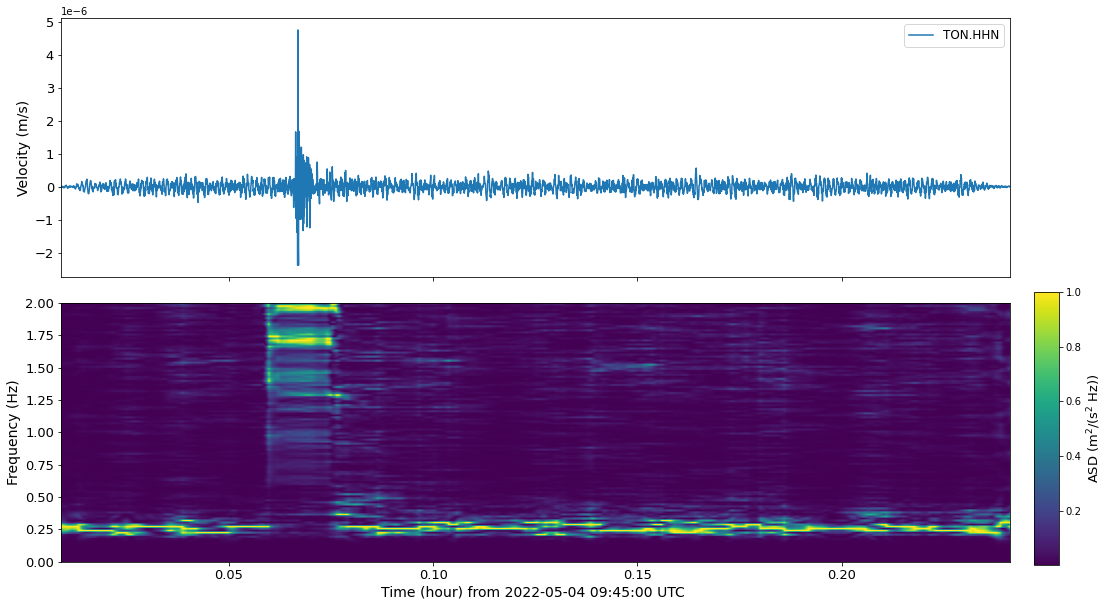

Using windows of 3.52 seconds 


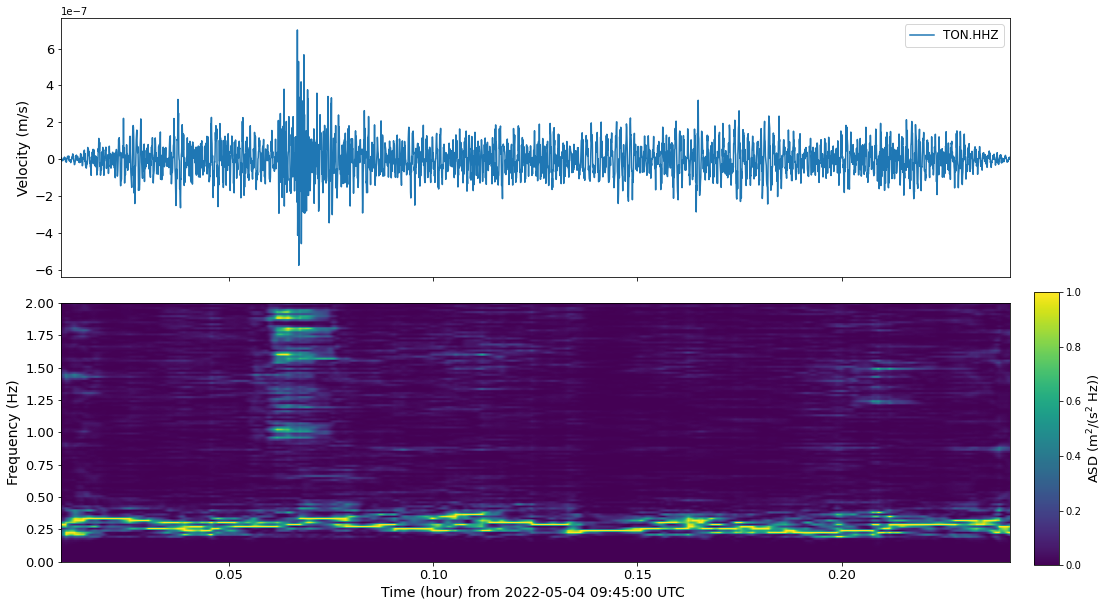

In [21]:
N = 256
params = [None, N, N-1]
for tr in st:
#     __makeplot_trace_spectrogram(tr, f_upper=config['filter_corners'][1], normalize=True, unit='hour');
    __makeplot_trace_spectrogram(tr, f_upper=config['filter_corners'][1], normalize=True, unit='hour', spec_param=params);

plt.show();

### Get Mass Volatge of BIB Centaur

In [22]:
st = obs.read("/bay200/mseed_online/archive/2022/BW/BIB/VM?.D/*")
st.merge()

3 Trace(s) in Stream:
BW.BIB.D0.VM1 | 2022-01-01T00:17:00.000000Z - 2022-05-04T14:36:00.000000Z | 60.0 s, 177980 samples (masked)
BW.BIB.D0.VM2 | 2022-01-01T00:00:00.000000Z - 2022-05-04T14:38:00.000000Z | 60.0 s, 177999 samples (masked)
BW.BIB.D0.VM3 | 2022-01-01T00:25:00.000000Z - 2022-05-04T14:35:00.000000Z | 60.0 s, 177971 samples (masked)

In [23]:
tbeg = obs.UTCDateTime("2022-01-01 15:30")
tend = obs.UTCDateTime("2022-01-31")
st.trim(starttime=tbeg, endtime=tend);

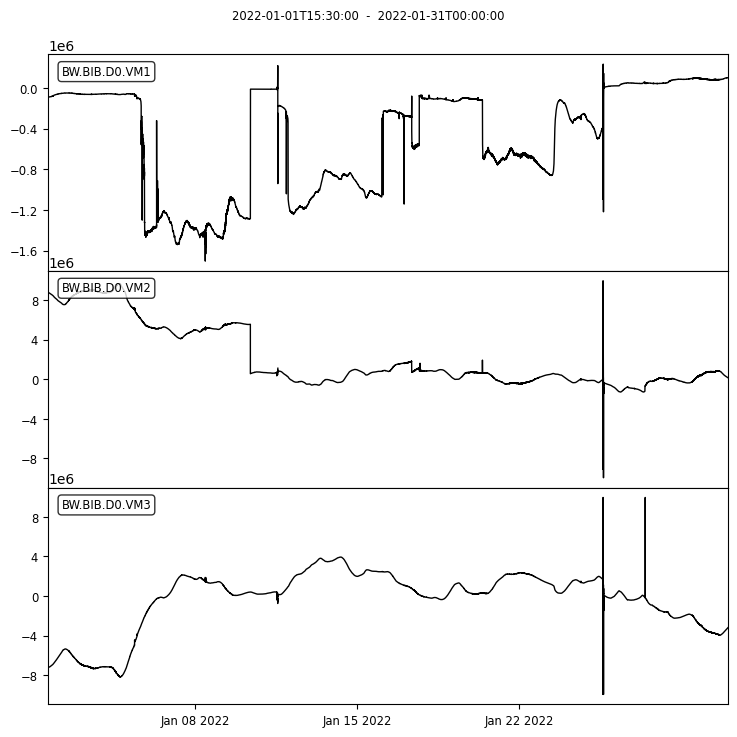

In [24]:
st.plot(equal_scale=False);

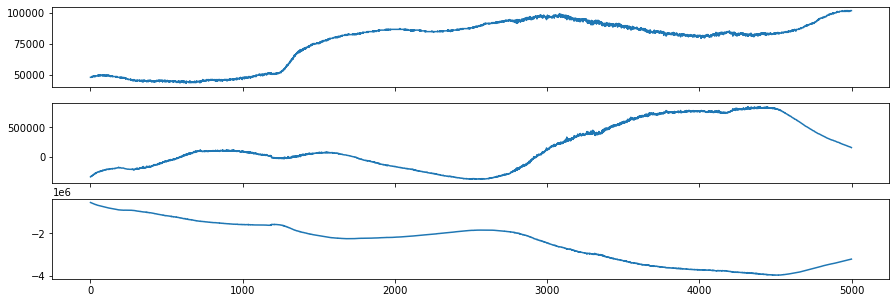

In [25]:
fig, ax = plt.subplots(3,1,figsize=(15,5), sharex=True)
for i,tr in enumerate(st):
    ax[i].plot(tr.data[-5000:]);
plt.show();

### Get Voltage of battery

In [26]:
V = obs.read("/bay200/mseed_online/archive/2022/BW/BIB/VEI.D/*")
V.merge()

1 Trace(s) in Stream:
BW.BIB.D0.VEI | 2022-01-01T00:10:00.000000Z - 2022-05-04T14:13:00.000000Z | 60.0 s, 177964 samples (masked)

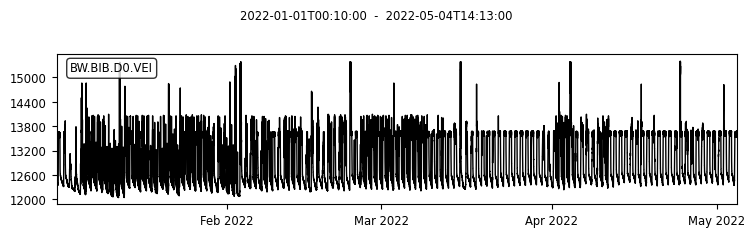

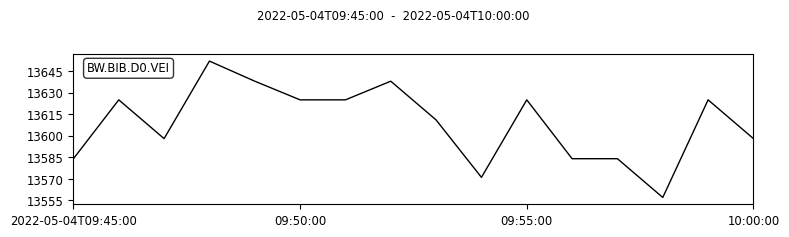

In [27]:
V.plot();

V_select = V.copy()
V_select.trim(obs.UTCDateTime(config['tbeg']), obs.UTCDateTime(config['tend']))
V_select.plot();